In [49]:
"""
# Old code that's too slow
l = []
begin = file_info['Sample Beginning Index']
bytes_per_sample = file_info['Block Align (bytes per sample)']
end = file_info['Sample Beginning Index'] + file_info['Num Samples'] * bytes_per_sample

for i in range(begin, end, bytes_per_sample):
    l.append(int.from_bytes(b[i: i + 2], "little", signed=True))

if (len(l) % 1024 != 0):
    for i in range(1024 - (len(l)%1024)):
        l.append(0)

assert len(l)%1024 == 0, "not padded correctly"
print(len(l))

for i in range(len(nl)):
    assert nl[i] == l[i]

#2048 samples * 96 frequencies* 2 values (sin, cos) * 8 bytes per float ~= 3MB

start = time.time()
#probably a faster way to do this
sample_rate = file_info['Sample Rate'] #Hz

sinmat = np.zeros((96,window))
cosmat = np.zeros((96,window))
for i in range(96):
    # 2 * pi * (note frequency (Hz))/(sampling rate (Hz))
    step = (6.28318530718 * N[Nk[i]][1])/sample_rate 
    radians = np.arange(0, step * window, step, dtype=np.float64)
    sinmat[i] = np.sin(radians)
    cosmat[i] = np.cos(radians)
#     for j in range(sample_len):
#         sinmat[i][j] = sin(j * freq)
#         cosmat[i][j] = cos(j * freq)
    
# numpsd = len(nl)//1024 - 1
# gabor = np.zeros((numpsd, 96))
mid = time.time()

rs_samples = np.reshape(samples, (window, len_samples//1024))
sin_s = np.matmul(sinmat, rs_samples)
cos_s = np.matmul(cosmat, rs_samples)
psd = (sin_s**2 + cos_s**2)
psd /= np.amax(psd)

# #probably a faster way to do this as well
# for i in range(numpsd):
#     s = i * 1024
#     e = s + 2048
#     si = np.matmul(sinmat, nl[s:e])
#     ci = np.matmul(cosmat, nl[s:e])
#     psd = (si**2 + ci**2)
#     gabor[i] = np.copy(psd)

# gabor /= np.amax(gabor)
end = time.time()
print("time taken to generate matrices: {}".format(mid-start))
print("time taken to do fourier transform: {}".format(end-mid))
print("total time: {}".format(end-start))
"""
pass

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import time

In [51]:
def parse_wav(b):
    assert b[0:4] == b'RIFF', "Chunk ID did not match 'RIFF'"
    chunk_size = int.from_bytes(b[4:8], byteorder="little")
    assert b[8:12] == b'WAVE', "Format did not match 'WAVE'"
    assert b[12:16] == b'fmt ', "Format subchunk ID did not match 'fmt '"
    chunk1_size = int.from_bytes(b[16:20], byteorder="little")
    audio_format = int.from_bytes(b[20:22], byteorder="little")
    assert audio_format == 1, "Audio Format is not PCM (i.e. data is compressed)"
    channels = int.from_bytes(b[22:24], byteorder="little")
    sample_rate = int.from_bytes(b[24:28], byteorder="little")
    byte_rate = int.from_bytes(b[28:32], byteorder="little")
    block_align = int.from_bytes(b[32:34], byteorder="little")
    bits_per_sample = int.from_bytes(b[34:36], "little")
    assert (bits_per_sample % 8) == 0 , "bits per sample is not a multiple of 8"
    assert (sample_rate * (bits_per_sample/8) * channels == byte_rate), "byte_rate != bytes_per_sample * sample_rate * num_channels"
    # from 36 onwards, we might have additional metadata
    data_idx = 36
    while True:
        temp_chunk_id = b[data_idx: data_idx + 4]
        temp_chunk_size = int.from_bytes(b[data_idx + 4: data_idx + 8], byteorder="little")
        if temp_chunk_id != b'data':
            data_idx += temp_chunk_size + 8 # add 8 to include the chunk_id and chunk_size fields
        else:
            break
            
    assert b[data_idx: data_idx + 4] == b'data', "Format subchunk ID did not match 'data'"
    sample_size = int.from_bytes(b[data_idx + 4: data_idx + 8], byteorder="little")
    sample_begin = data_idx + 8
    assert sample_size % block_align == 0, "size of sample in bytes is not divisible by number of bytes per sample"
    return {
        "File Size": chunk_size + 8,
        "Audio Format": "PCM",
        "Channels": channels,
        "Sample Rate": sample_rate,
        "Byte Rate": byte_rate,
        "Block Align (bytes per sample)": block_align,
        "Bits Per Sample Per Channel": bits_per_sample,
        "Samples Size": sample_size,
        "Num Samples": int(sample_size/block_align),
        "File Length (seconds)": round(sample_size/(byte_rate), 3),
        "Sample Beginning Index": sample_begin,
    }

In [52]:
# Clean Code
def gen_psd(byte_arr, window):
    start = time.time()

    file_info = parse_wav(byte_arr)
    num_samples = file_info['Num Samples']
    len_samples = num_samples if (num_samples%window == 0) else (window * (num_samples//window + 1))
    assert len_samples % window == 0
    samples = np.zeros(len_samples, dtype=np.int16)
    samples[:num_samples] = np.frombuffer(byte_arr[file_info['Sample Beginning Index']:], dtype=np.int16)
    samples = samples.astype(np.float64)
    samples /= 2**15 #normalize to [-1,1] range

    mid1 = time.time()

    num_notes = len(pitches)
    sample_rate = file_info['Sample Rate'] #Hz
    sinmat = np.zeros((num_notes, window))
    cosmat = np.zeros((num_notes, window))
    for i in range(num_notes):
        # 2 * pi * (note frequency (Hz))/(sampling rate (Hz))
        step = (6.28318530718 * pitches[i])/sample_rate 
        radians = np.arange(0, step * window, step, dtype=np.float64)[:window] 
        #need [:window] for floating point error
        sinmat[i] = np.sin(radians)
        cosmat[i] = np.cos(radians)   
    rs_samples = np.reshape(samples, (window, len_samples//window))

    mid2 = time.time()

    sin_s = np.matmul(sinmat, rs_samples)/window
    cos_s = np.matmul(cosmat, rs_samples)/window
    #FLOPs = 2 * (96 * window * len_samples/window) + 2 * (96 * len_samples/window) 
    #      = 2 * 96 * (window + 1) * (len_samples/window)
    #      = O(n)
    psd = (sin_s**2 + cos_s**2)**0.5

    end = time.time()

    stats = "read samples: {:.1f}ms \ngenerate matrices: {:.1f}ms \ngemm: {:.1f}ms \ntotal: {:.1f}ms".format(
        1000 * (mid1-start),
        1000 * (mid2-mid1),
        1000 * (end-mid2),
        1000 * (end-start)
    )
    
    return {
        "file_info": file_info,
        "stats": stats,
        "samples": samples,
        "psd": np.transpose(psd),
        "sin": np.transpose(sin_s),
        "cos": np.transpose(cos_s),
    }

def plot_window(n, samples, window):
    plt.figure(figsize=(24,8))
    plt.plot(samples[n*window:(n+1)*window])

In [56]:
names = ['A','Bb','B','C','Db','D','Eb','E','F','Gb','G','Ab']
all_notes = {}
for i in range(120):
    all_notes[names[i%12] + str(i//12)] = round(27.5*2**(i/12),4)
#Anything above A8 is not very musical, same with things below A2
# https://www.szynalski.com/tone-generator/

WINDOW = 8192 # 1/36 of a second
NOTES = []
for i in range(0, 120):
    NOTES.append((round(27.5*2**(i/12),4), names[i%12] + str(i//12), i))

NAMES = list(zip(*NOTES))[1]

In [57]:
pitches = []
for i in range(120):
    base = 27.5*2**(i/12)
    pitches.append(base)
    for j in range(2,20):
        if (base * j < 20000):
            pitches.append(base * j)
        else:
            break

pitches.sort()
pitches = list(filter(lambda x: x < 20000, map(lambda x: round(x, 2), pitches)))
pitches = list(dict.fromkeys(pitches))

In [58]:
f = open("sirduke.wav", "rb")
b = f.read()
f.close()

info = gen_psd(b, WINDOW)
print(info['stats'])
print(info['file_info'])

read samples: 161.7ms 
generate matrices: 232.1ms 
gemm: 395.9ms 
total: 789.7ms
{'File Size': 20510798, 'Audio Format': 'PCM', 'Channels': 1, 'Sample Rate': 44100, 'Byte Rate': 88200, 'Block Align (bytes per sample)': 2, 'Bits Per Sample Per Channel': 16, 'Samples Size': 20510720, 'Num Samples': 10255360, 'File Length (seconds)': 232.548, 'Sample Beginning Index': 78}


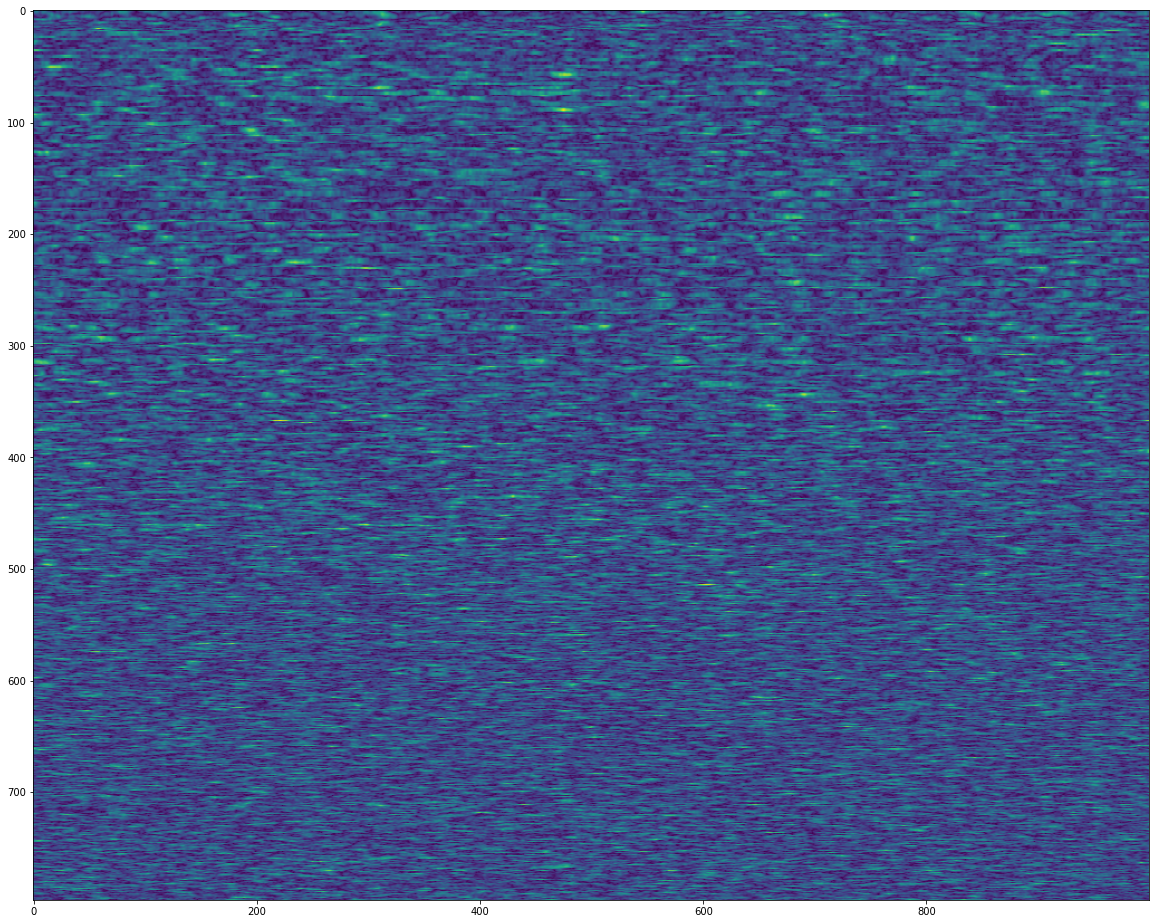

In [59]:
psd = info['psd']
fig, ax = plt.subplots(figsize=(20,100))
im = ax.imshow(psd[:1000].T)

In [61]:
def find_peaks(psd_row):
    num_notes = len(pitches)
    assert len(psd_row) == num_notes
    ret = np.zeros(num_notes, dtype=np.uint8)
    if psd_row[0] > psd_row[1]:
        ret[0] = 1
    if psd_row[-1] > psd_row[-2]:
        ret[-1] = 1
    for i in range(1, num_notes-1):
        if psd_row[i-1] < psd_row[i] and psd_row[i+1] < psd_row[i]:
            ret[i] = 1
    return ret

def find_peaks_2(psd_row, top = 16):
    num_notes = len(pitches)
    assert len(psd_row) == num_notes
    ret = np.zeros(num_notes, dtype=np.uint8)
    
    l = list(enumerate(psd_row))
    l.sort(key=lambda x: x[1], reverse=True)
    
    for i in range(top):
        ret[l[i][0]] = 1
    
    return ret
    
# find_peaks(psd[50])

In [64]:
peaks = np.zeros(psd.shape, dtype=np.uint8)
for i,row in enumerate(psd):
    peaks[i] = find_peaks(row)

# fig, ax = plt.subplots(figsize=(20,100))
# im = ax.imshow(peaks[:200].T)

In [65]:
def inverse(s_sin, s_cos, peaks, window):
    ret = np.zeros(window, dtype=np.float64)
    sample_rate = 44100
    for i,note in enumerate(pitches):
        if peaks[i] == 1:
            step = (6.28318530718 * note)/sample_rate 
            radians = np.arange(0, step*window, step, dtype=np.float64)[:window]
            ret += ((np.sin(radians) * s_sin[i]) + (np.cos(radians) * s_cos[i]))#amplitude
    return ret

In [ ]:
w = 32
plt.figure(figsize=(24,8))
plt.plot(info['samples'][w*WINDOW:(w+1)*WINDOW])
plt.plot(inv := inverse(info['sin'][w], info['cos'][w], np.ones(len(psd[w]), dtype=np.int8), WINDOW))

In [ ]:
sample2 = np.concatenate([inverse(info['sin'][w], info['cos'][w], find_peaks_2(psd[w], top=4), WINDOW) for w in range(len(psd))], axis=0) * 2**15

In [ ]:
sample2 = sample2.astype(np.int16)

In [ ]:
sample2[:100]

In [ ]:
b[:78]

In [ ]:
f = open("new.wav", "wb")
f.write(b[:78])


In [ ]:
for i in range(info['file_info']['Num Samples']):
    f.write(sample2[i])

In [ ]:
f.close()

In [ ]:
samples = info['samples']

In [ ]:
fi = info['file_info']
fi

In [ ]:
fi['Num Samples'] % 8192

In [ ]:
len(samples) % 8192

In [ ]:
samples

In [4]:
from scipy.fft import rfft, irfft
import math

In [67]:
f = open("orch.wav", "rb")
bb = f.read()
f.close()

window = 1024

file_info = parse_wav(bb)

num_samples = file_info['Num Samples']
print("num samples: ", num_samples)
samples = np.zeros(num_samples + (window - num_samples%window), dtype=np.int16)
samples[:num_samples] = np.frombuffer(bb[file_info['Sample Beginning Index']:], dtype=np.int16)
samples = samples.astype(np.float64)
samples /= 2**15

num samples:  3395700


In [104]:
def get_percent_yinv(winnum, samples, recon=0.9, window=1504, visual=False):
#     winnum = 58
#     window = 1504 # 47 * 32, alternate value is 1490

    yf = rfft(samples[window*winnum:window*(winnum + 1)])
    ay = np.abs(yf)
    
    if visual:
        plt.figure(figsize=(24,8))
        plt.bar(range(len(yf)), ay)

    l = list(zip(range(len(ay)), ay))
    l.sort(key=lambda x: x[1], reverse=True)

    p1 = 0
    p2 = 0
    num_top = 2048
    dnt = num_top//2
    
#     recon = 0.9

    while not(p1 < recon and p2 >= recon):
        yinv_d = None
        yf2 = np.copy(yf)
        top = l[num_top + 1][1]

        for i in range(len(yf2)):
            if np.abs(yf2[i]) <= top:
                yf2[i] = 0
            

        yinv_d = irfft(yf2)
        p2 = 1 - np.linalg.norm(yinv_d-samples[window*winnum:window*(winnum + 1)])/np.linalg.norm(samples[window*winnum:window*(winnum + 1)])

        top = l[num_top][1]
        for i in range(len(yf2)):
            if np.abs(yf2[i]) <= top:
                yf2[i] = 0

        yinv_d = irfft(yf2)
        p1 = 1 - np.linalg.norm(yinv_d-samples[window*winnum:window*(winnum + 1)])/np.linalg.norm(samples[window*winnum:window*(winnum + 1)])
        
        if visual:
            print("reconstruction (num_top + 1), num_top : ", p2, p1, " num_top, dnt: ", num_top, dnt)

        if (p1 >= recon):
            num_top -= dnt
            dnt //= 2
        elif (p2 < recon):
            num_top += dnt
            dnt //= 2
        
        yf2 = None
        yinv_d = None
        
        if (num_top + 1 >= len(l)):
            num_top = len(l) - 2
            break
        
        if (num_top == 1):
            break
    
    yf = rfft(samples[window*winnum:window*(winnum + 1)])
    ay = np.abs(yf)

    l = list(zip(range(len(ay)), ay))
    l.sort(key=lambda x: x[1], reverse=True)

    tops = []
#     print(len(l), num_top + 1)
    top = l[num_top + 1][1]
    for i in range(len(yf)):
        if np.abs(yf[i]) <= top:
            yf[i] = 0
        else:
            tops.append((i, i * (44100/window), np.abs(yf[i])))
    tops.sort(key=lambda x: x[2], reverse=True)
    
    if visual:
        plt.bar(range(len(yf)), np.abs(yf))

    yinv = irfft(yf)

    pfin = 1 - np.linalg.norm(yinv-samples[window*winnum:window*(winnum + 1)])/np.linalg.norm(samples[window*winnum:window*(winnum + 1)])
    if visual:
        print("final number of entries: ", num_top + 1)
        print("final reconstruction: ", pfin)
    
    return (tops, yinv, pfin)

reconstruction (num_top + 1), num_top :  0.9904954730197552 0.9904867591955769  num_top, dnt:  2048 1024
reconstruction (num_top + 1), num_top :  0.9681005846118704 0.9680513004390686  num_top, dnt:  1024 512
reconstruction (num_top + 1), num_top :  0.9194821097791249 0.9193028092951999  num_top, dnt:  512 256
reconstruction (num_top + 1), num_top :  0.8380839591438869 0.8375246129039784  num_top, dnt:  256 128
reconstruction (num_top + 1), num_top :  0.8905623209664928 0.8902725380148334  num_top, dnt:  384 64
reconstruction (num_top + 1), num_top :  0.9067421086535871 0.9065276366108038  num_top, dnt:  448 32
reconstruction (num_top + 1), num_top :  0.8994194823280265 0.8991733931107563  num_top, dnt:  416 16
reconstruction (num_top + 1), num_top :  0.903182204120476 0.9029553094977277  num_top, dnt:  432 8
reconstruction (num_top + 1), num_top :  0.9013437668513509 0.9011076627472812  num_top, dnt:  424 4
reconstruction (num_top + 1), num_top :  0.9003897646294177 0.9001493325789015

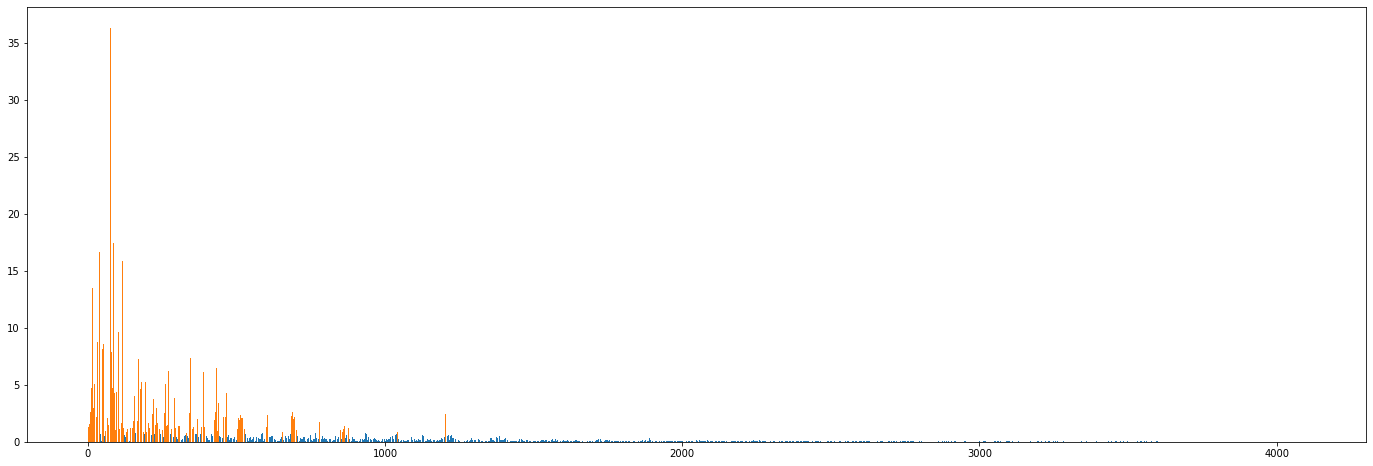

In [109]:
window = 8192
winnum = 48
tops, yinv, pfin = get_percent_yinv(winnum, samples, recon=0.90, window=window, visual=True)

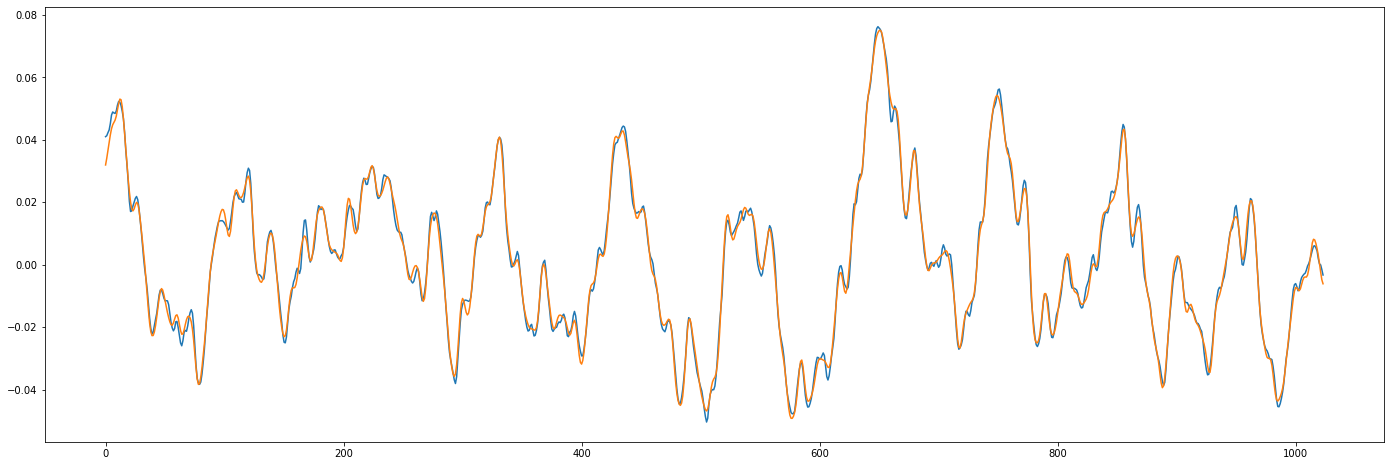

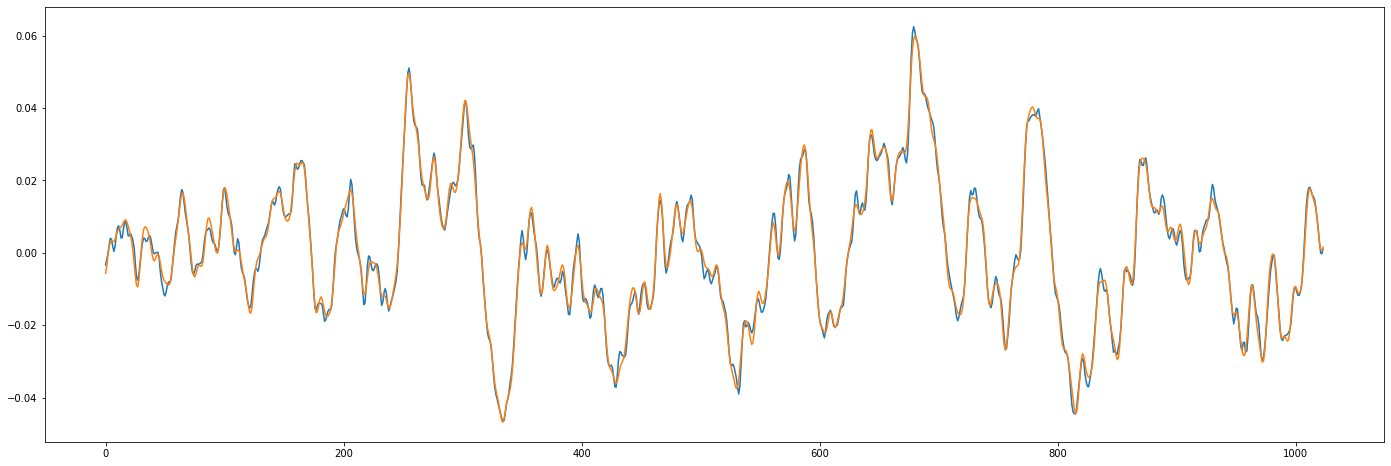

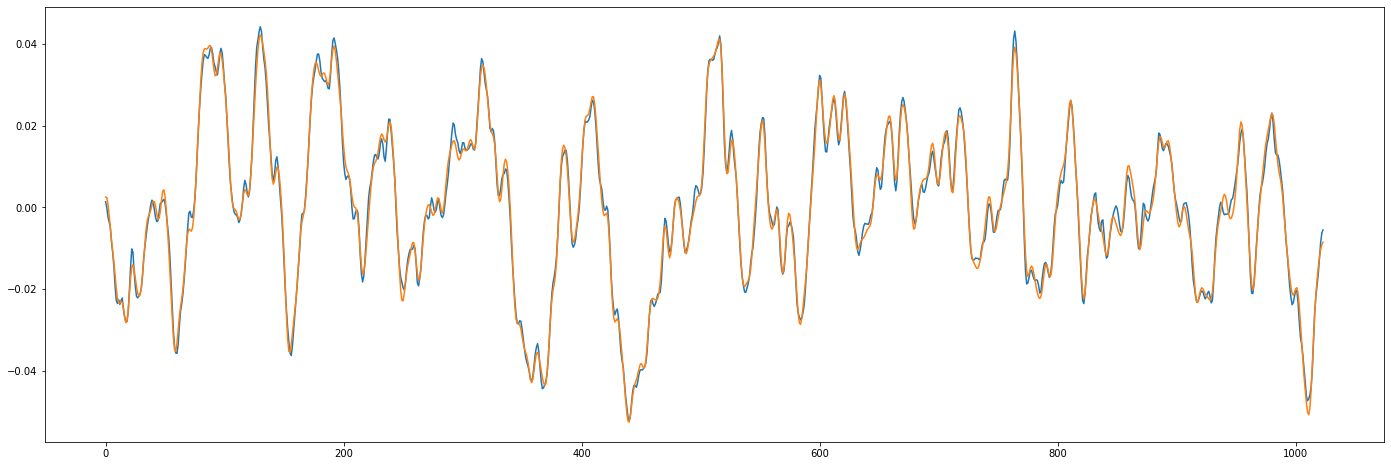

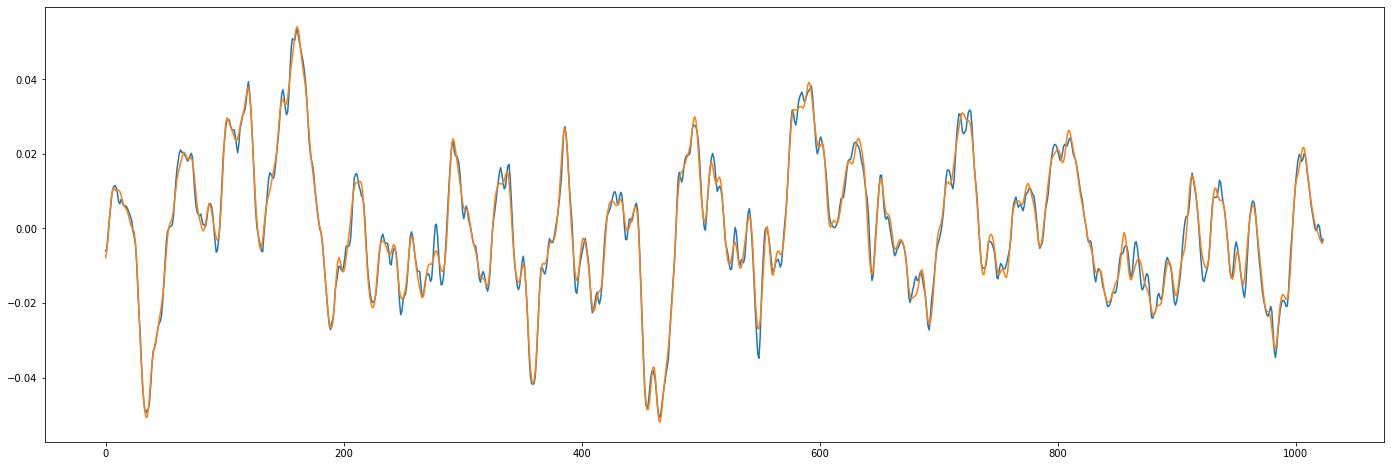

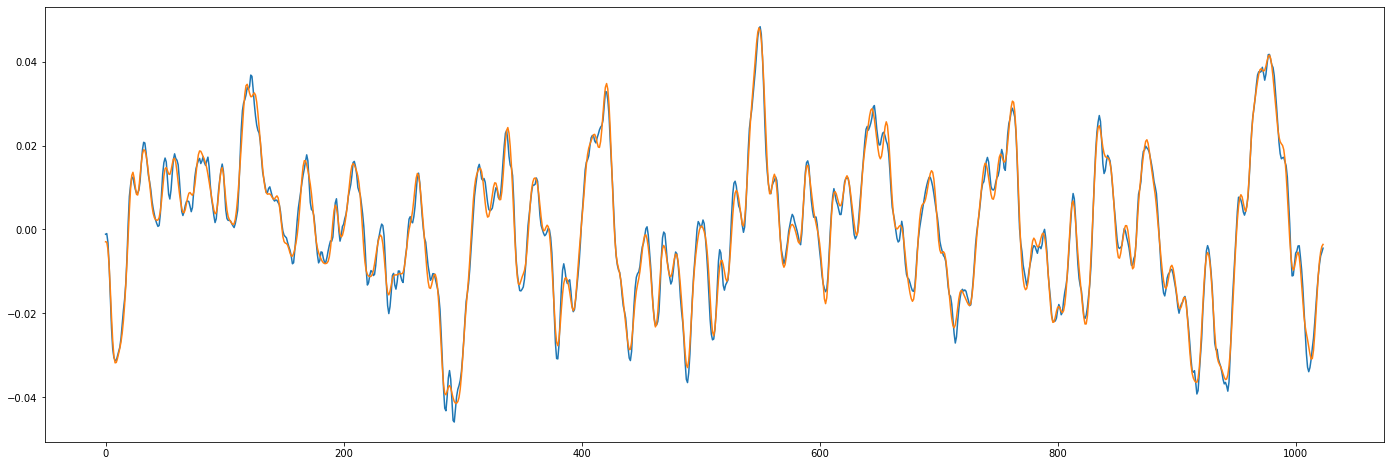

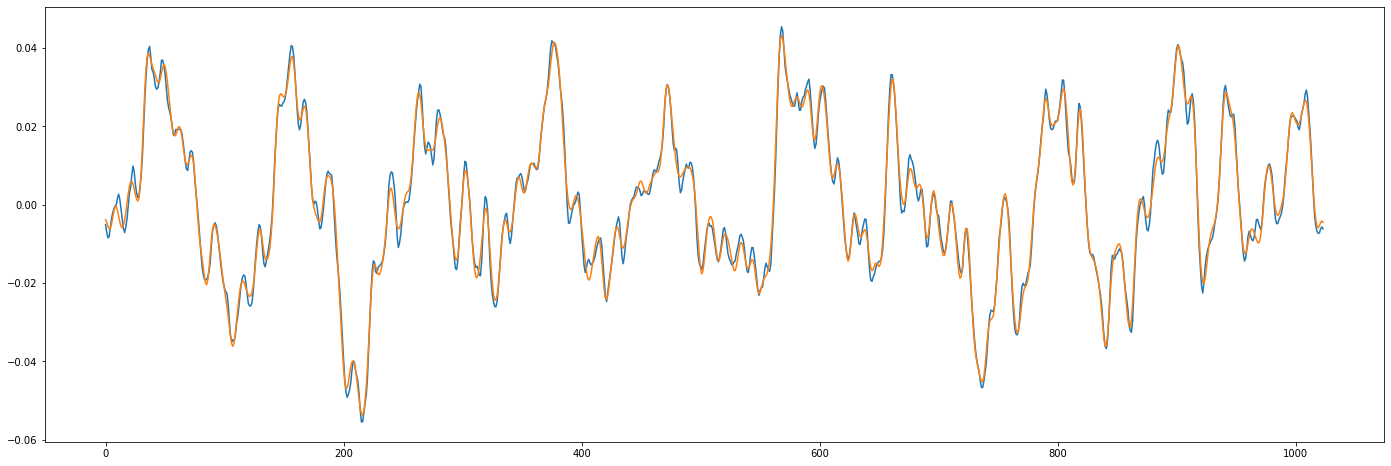

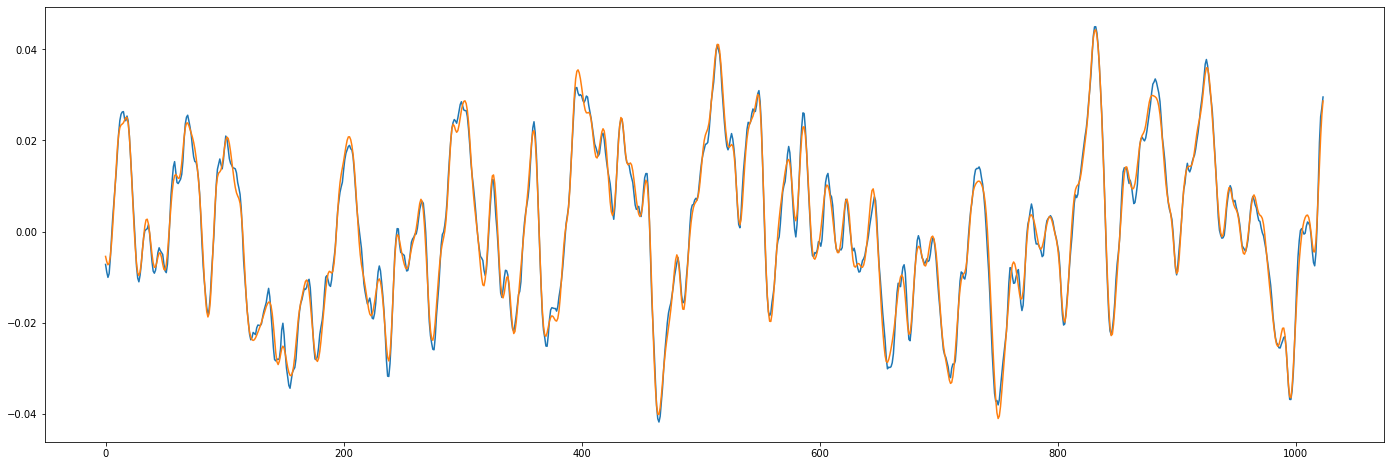

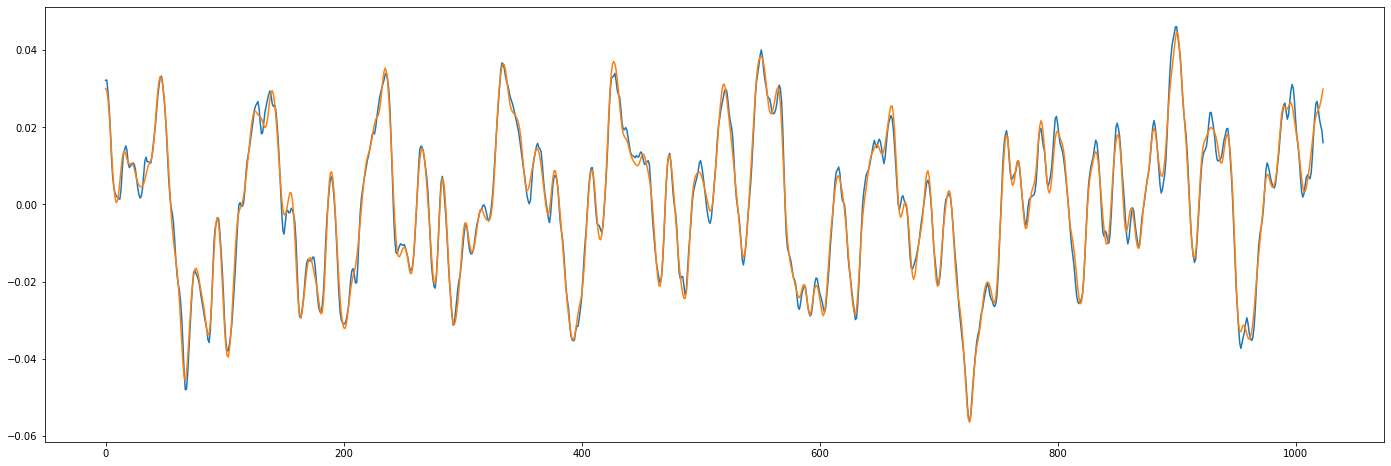

8192

In [110]:
for subwin in range(8):
# subwin = 6
    plt.figure(figsize=(24,8))
    plt.plot(samples[window*winnum:window*(winnum + 1)][1024*subwin:(subwin+1)*1024])
    plt.plot(yinv[1024*subwin:(subwin+1)*1024])
    plt.show()
# plt.plot(samples[3439800:3439800+2048])
len(yinv)

In [28]:
start_time = time.time()

f = open("orch.wav", "rb")
bb = f.read()
f.close()

window = 1504

file_info = parse_wav(bb)

num_samples = file_info['Num Samples']
print("num samples: ", num_samples)
samples = np.zeros(num_samples + (window - num_samples%window), dtype=np.int16)
samples[:num_samples] = np.frombuffer(bb[file_info['Sample Beginning Index']:], dtype=np.int16)
samples = samples.astype(np.float64)
samples /= 2**15

ns = num_samples
print(ns)

f = open("orch-75.wav", "wb")
f.write(bb[:78])

# fft_samples = np.zeros(ns + (window - (ns % window)), dtype=np.int16)

for i in range(0, len(samples), window):
    
    print((i/ns)*100, end="\r")
    
    if np.linalg.norm(samples[i:i+window]) != 0:
        if num_samples - i >= window:
            tops, yinv, pfin = get_percent_yinv(i//window, samples, recon=0.75, window=window, visual=False)

            for j in range(window):
                if (i+j < ns):
                    f.write((yinv[j] * (2**15)).astype(np.int16))
        else:
            for j in range(num_samples - i):
                zero = np.zeros(1, dtype=np.int16)
                if (i+j < ns):
                    f.write((zero[0]).astype(np.int16))
    else:
        for j in range(window):
            zero = np.zeros(1, dtype=np.int16)
            if (i+j < ns):
                f.write((zero[0]).astype(np.int16))

f.close()
end_time = time.time()
print("Done: ", round(end_time - start_time, 3), " seconds taken")

num samples:  3395700
3395700
Done:  70.194  seconds taken


In [ ]:
f = open("new4.wav", "rb")
bb = f.read()
f.close()

file_info = parse_wav(bb)

num_samples = file_info['Num Samples']
print("num samples: ", num_samples)
# samples = np.zeros(num_samples + (window - num_samples%window), dtype=np.int16)
samples = np.frombuffer(bb[file_info['Sample Beginning Index']:], dtype=np.int16)
samples = samples.astype(np.float64)
samples /= 2**15

plt.plot(samples[8192 + 1024 + 512:8192 + 512+2048])

In [36]:
# more fft things now that I realize the number corresponds to how many full cycles in the given time domain
def near(freq):
    ret = []
    for note in NOTES:
        pitch = note[0]
#         if freq/pitch <= 1.029 and pitch/freq >= 0.972: #less than 1/2 away from note
        if freq/pitch <= 1.0195 and pitch/freq <= 1.0195: #less than 1/3 away from note
#         if freq/pitch <= 1.0146 and pitch/freq <= 1.0146: #less than 1/3 away from note
        
            return note[1]
    return None
        
l = []
# for window in range(1024, 2048+1024+1):
window = 3007
sample_rate = 44100
# print("sampling frequency", sample_rate/window, "times per second")
cover = set()
for i in range(1, window//2):
    hz = i * (sample_rate/window)
    note = near(hz)
    if note:
        cover.add(note)
    print(hz, note)

# print(cover)

note_names = set([n[1] for n in NOTES])
assert cover.issubset(note_names)
missing = list(filter(lambda x: x[-1] in ['3','4','5','6','7'], note_names - cover))
print(len(missing))
missing


14.665779847023611 None
29.331559694047222 Bb0
43.99733954107083 F0
58.663119388094444 Bb1
73.32889923511806 D1
87.99467908214166 F1
102.66045892916527 Ab1
117.32623877618889 Bb2
131.9920186232125 C2
146.65779847023612 D2
161.32357831725972 None
175.98935816428332 F2
190.65513801130695 None
205.32091785833055 Ab2
219.98669770535417 A3
234.65247755237777 Bb3
249.31825739940138 B3
263.984037246425 C3
278.64981709344863 Db3
293.31559694047223 D3
307.98137678749583 Eb3
322.64715663451943 None
337.31293648154303 None
351.97871632856663 F3
366.6444961755903 Gb3
381.3102760226139 None
395.9760558696375 G3
410.6418357166611 Ab3
425.3076155636847 None
439.97339541070835 A4
454.63917525773195 None
469.30495510475555 Bb4
483.97073495177915 None
498.63651479880275 B4
513.3022946458264 C4
527.96807449285 C4
542.6338543398736 None
557.2996341868973 Db4
571.9654140339209 None
586.6311938809445 D4
601.2969737279681 None
615.9627535749917 Eb4
630.6285334220153 Eb4
645.2943132690389 None
659.96009311606

1


['E3']

In [ ]:
1024 + 128

In [ ]:
note_names = set([n[1] for n in NOTES])
assert cover.issubset(note_names)
missing = list(filter(lambda x: x[-1] in ['3','4','5','6','7'], note_names - cover))
missing

In [ ]:
l = []
sample_rate = 44100
for window in range(1024, 2048+1024+1):
    # window = 1025
    freq = [i * (sample_rate/window) for i in range(1, window+1)]
    match = all_notes['B4']
    closest = map(lambda match: min(map(lambda x: x/match if x >= match else match/x, freq)), [(27.5 * 2**(i/12)) for i in range(24, 96)])
    ans = np.prod(list(closest))
    l.append((window, ans))
l

In [ ]:
l.sort(key=lambda x: x[1])
l

In [ ]:
l.sort(key=lambda x: x[0])

In [ ]:
x = [i[0] for i in l]
y = [i[1] for i in l]
plt.figure(figsize=(24,8))

In [ ]:
plt.plot(y)

In [ ]:
l

In [ ]:
#local minima:
# 1072, 1136, 1203, 1274, 1350, 1430, 1515, 1605, 

In [ ]:
local_min = []
local_min.append(l[0])
for i in range(1, len(l) - 1):
    if l[i-1][1] > l[i][1] and l[i+1][1] > l[i][1]:
        if l[i][1] < local_min[-1][1]:
            local_min.append(l[i])

In [ ]:
local_min

In [ ]:
plt.plot([i[1] for i in local_min])
plt.show()

In [ ]:
# 1135 seems like a good choice, so does 1490
my = max(y)
mx = max(x)

In [ ]:
narr = [(ll[0], int(math.log(ll[0] & -(ll[0]),2)), (my/ll[1])/(ll[0]), ll[1]) for ll in l]

In [ ]:
plt.plot([n[2] for n in narr])
plt.show()

In [ ]:
narr.sort(key=lambda x: x[2], reverse=True)

In [37]:
narr

NameError: name 'narr' is not defined

In [48]:
all_notes['Bb2'] - all_notes['A2']

6.5408999999999935

In [44]:
44100/1504

29.3218085106383